In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import h5py
import glob
import copy
import datetime as dt

In [187]:
### Inicio de la parte que requiere modificacion por el usuario

# nombre del sitio, extension, tipo de fuente (e.g. LtCO2 o target)
# para generar titulo del grafico y nombre de archivo de salida
location_name = 'Vallejo'
size = '5km'
sourcetype = 'OCO2target'
plotname = location_name + ' ' + size + ' ' + sourcetype
filename = location_name + '_' + size + '_' + sourcetype

# direccion de los archivos HDF de entrada y salidda 
# nombre semilla de los archivos (e.g. mexico_oco3_target, o mexico_oco3_early)
path_hdfin = "D:\\CCA\\NASAGESDISC\\OCO2\\MEXICO_STD\\"
seedname = 'mexico_co2_oco2_'
path_hdfout = "D:\\CCA\\NASAGESDISC\\OCO2\\timeseries_std\\"
path_plotout = "D:\\CCA\\NASAGESDISC\\OCO2\\timeseries_std\\"
name_hdfout = path_hdfout + filename + '_20210504.h5'
name_plotout = path_plotout + filename + '_20210504.png'

# nombre en el archivo HDF de las variables de latitud (y), longitud (x), y de interes (z)
# aqui se incluye el nombre de POSIX (tepoch) por si se llegase a cambiar
# NOTA, estos valores tienen que ser escalares, vectores (e.g. columna de co2) van a generar error
latname = '/RetrievalGeometry/retrieval_latitude'
lonname = '/RetrievalGeometry/retrieval_longitude'
zname = '/RetrievalResults/xco2'
#latname = 'lat'
#lonname = 'lon'
#zname = '/xco2'
epochname = 'tepoch'

# inicializacion de las condiciones : anyo, mes (o meses), punto de interes (lat y lon), tamanyo de grid deseado
years = [2021]
months = np.arange(5,6)                           # np.arange(n,m) genera un arreglo con primer elemento n y ultimo m-1
latpoint = 19.483781                               # latitud del punto de interes
lonpoint = -99.147                                 # longitud del punto de interes
radiuskm = 5                                  # radio del grid en km
gridsize = radiuskm/110.567                  # tamanyo del grid en fraccion de grados

### Fin de la parte que requiere moddificacion por el usuario

In [188]:
# Esta seccion genera una matriz 3x3x2 con las coordenadas +- 1 grado de latitud y longitud de las seccion del punto de interes
# e.g para 19N-98W genera un grid 9x9 que va de 20N-99W a 18N-97W

# Dependiendo del punto de interes y del tamanyo del area en fraccion de grados; una, varias, o todas las celdas del grid 9x9 
# entraran en los datos que se buscan

# Se genera un filtro para construir las diferentes etiquetas xN-yW para accesar a las carpetas del archivo HDF y obtener los
# datos 

# latitud y longitud maxima y minima
grid_max_lat = latpoint + gridsize
grid_min_lat = latpoint - gridsize
grid_max_lon = lonpoint - gridsize
grid_min_lon = lonpoint + gridsize

# convertir los float a integer
gridlat = int(latpoint)
gridlon = int(lonpoint)
gridmaxlat = int(grid_max_lat)
gridminlat = int(grid_min_lat)
gridmaxlon = int(grid_max_lon)
gridminlon = int(grid_min_lon)

# vectores de latitud y longitud
latvector = [gridlat-1,gridlat,gridlat+1]
lonvector = [gridlon+1,gridlon,gridlon-1]

# matriz 3x3x2 con los grids individuales de latitud y longitud
# creada a mano, quiza haya una forma de hacerla menos explicita?
grid9x9 = np.array([[[latvector[2],lonvector[2]],[latvector[2],lonvector[1]],[latvector[2],lonvector[0]]], \
                   [[latvector[1],lonvector[2]],[latvector[1],lonvector[1]],[latvector[1],lonvector[0]]], \
                   [[latvector[0],lonvector[2]],[latvector[0],lonvector[1]],[latvector[0],lonvector[0]]]])

# filtro para seleccionar los grids que cubre el punto central con el tamanyo de grid
mask = (grid9x9[:,:,0] >= gridminlat) & (grid9x9[:,:,0] <= gridmaxlat) & (grid9x9[:,:,1] <= gridminlon) & (grid9x9[:,:,1] >= gridmaxlon)

In [189]:
# contadores inevitables
cont = 0                              # para saber que hacer si la matriz de datos ya se creo o no

In [190]:
# testing
#print(gridmaxlat,gridminlat,gridmaxlon,gridminlon)
#
#print(mask)
#
#print(grid9x9[mask])
#
#for row in grid9x9[mask]:
#    gridname = '%iN%iW' % (int(row[0]),int(row[1]))
#    print(gridname)

In [191]:
# algoritmo para generar la matriz de todos los datos en el grid 1x1 de los diferentes hdf
# este arrojara la matriz que despues se filtrara para hacer las series de tiempo
for year in years:
    for month in months:
        h5name = "%i%02i.h5" %(year,month)
        h5file = path_hdfin + seedname + h5name
        print('Intentando con el archivo: ', h5file)
        
        try:
            data = h5py.File(h5file,'r')
            
            for coords in grid9x9[mask]:
                
                gridname = '%iN%iW' % (coords[0],coords[1])
                #print(gridname)
                
                try:
                    # Toma las coordenadas del gris 1x1 y filtra los datos en una matriz temporal
                    # genera una matriz permanente que acumula los datos de las diferentes fechas
                    # y los diferentes gris
                    
                    lat = data[gridname][latname]
                    lon = data[gridname][lonname]
                    
                    # condiciones para reducir el tamaño del grid alrededor del punto seleccionado y obtener datos dentro de ese nuevo grid
                    distances2=np.array((lat-latpoint)**2+np.cos(np.pi/180.0*latpoint)**2*(lon-lonpoint)**2)
                    gridcond=(gridsize**2 > distances2)

                    #filterdata = datos[gridname][gridcond]

                    mat = data[gridname][gridcond]
        
        
                    if cont == 0:
                        # copia la matriz temporal en una permanente
                        # esto solo se debe usar si no existe ya la matriz permanente
                        datos=copy.copy(mat)
            
                    else:
                        # concatena los datos de la matriz temporal en la permanente
                        # esto solo se debe usar si ya existe la matriz permanente
                        datos=np.concatenate((mat,datos),axis=0)
                    
                    cont = cont + 1
                    print('Matriz temporal:', mat.shape)
                    print('Datos filtrados: ', datos.shape)
                    print('Datos fuente: ', data[gridname].shape)
                
                except:
                    print('no hay datos para %iN%iW' %(coords[0],coords[1]))
                    continue
                           
            data.close()
                    
        except:
            print('no hay datos para %i-%02i' %(year,month))
            continue
    

Intentando con el archivo:  D:\CCA\NASAGESDISC\OCO2\MEXICO_STD\mexico_co2_oco2_202105.h5
Matriz temporal: (65,)
Datos filtrados:  (65,)
Datos fuente:  (3896,)


In [193]:
fh5=h5py.File(name_hdfout,'w')
dset=fh5.create_dataset(filename,data=datos,maxshape=(None,))
fh5.flush()
fh5.close()

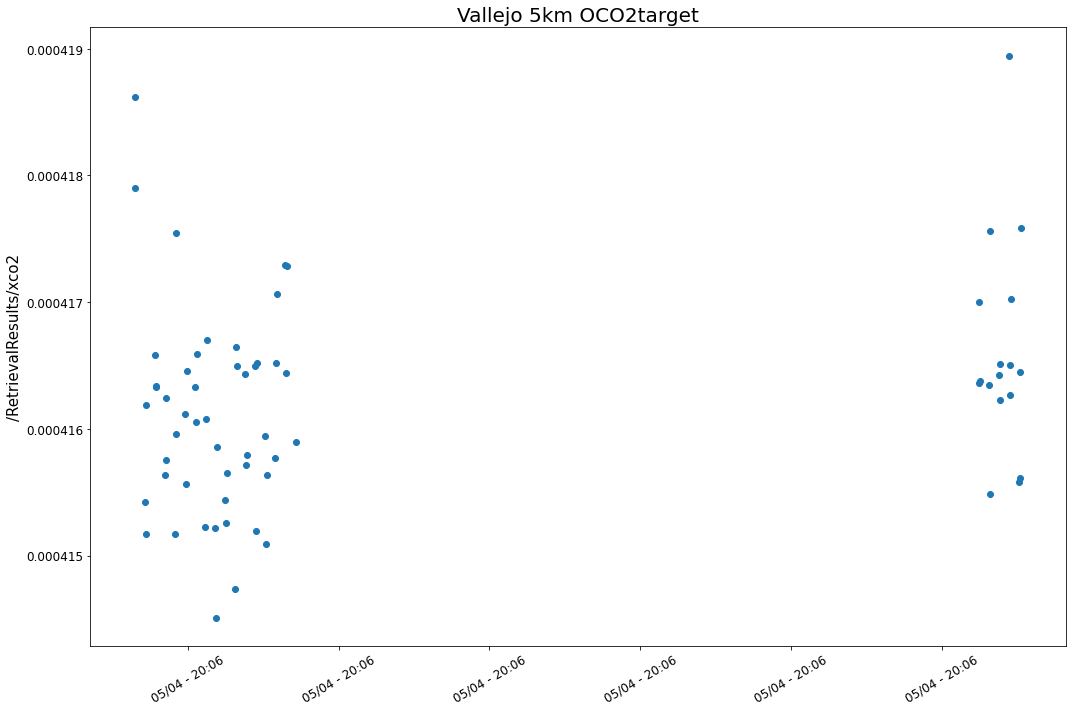

In [192]:
# grafica una serie de tiempo sencilla con los datos filtrados por las condiciones
time = np.array([dt.datetime.utcfromtimestamp(ele) for ele in datos[epochname]]) 
locator = mdates.AutoDateLocator()
formatter = mdates.DateFormatter('%m/%d - %H:%M')
fig, ax = plt.subplots(figsize=(15,10))
plt.plot_date(time,datos[zname]) 
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_tick_params(rotation=30, labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
#plt.xlabel('Date')
plt.ylabel(zname, size =15)
plt.title(plotname, size =20)
plt.tight_layout()
plt.savefig(name_plotout)
plt.show()

In [ ]:
# testing
# print(datos[:,0])
#print(datos[:,1])
#print(datos[:,2])